<a href="https://colab.research.google.com/github/Mohbad88/tp_middleware/blob/main/TP_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Building blocks of a CNN

This part introduces typical CNN building blocks, such as ReLU units and linear filters. For a motivation for using CNNs over fully-connected neural networks, see [[Le Cun, et al, 1998]](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [15]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu121
False


## Convolution

A feed-forward neural network can be thought of as the composition of number of functions
$$
f(\mathbf{x}) = f_L(\dots f_2(f_1(\mathbf{x};\mathbf{w}_1);\mathbf{w}_2)\dots),\mathbf{w}_{L}).
$$
Each function $f_l$ takes as input a datum $\mathbf{x}_l$ and a parameter vector $\mathbf{w}_l$ and produces as output a datum $\mathbf{x}_{l+1}$. While the type and sequence of functions is usually handcrafted, the parameters $\mathbf{w}=(\mathbf{w}_1,\dots,\mathbf{w}_L)$ are *learned from data* in order to solve a target problem, for example classifying images or sounds.

In a *convolutional neural network* data and functions have additional structure. The data $\mathbf{x}_1,\dots,\mathbf{x}_n$ are images, sounds, or more in general maps from a lattice$^1$ to one or more real numbers. In particular, since the rest of the practical will focus on computer vision applications, data will be 2D arrays of pixels. Formally, each $\mathbf{x}_i$ will be a $M \times N \times K$ real array of $M \times N$ pixels and $K$ channels per pixel. Hence the first two dimensions of the array span space, while the last one spans channels. Note that only the input $\mathbf{x}=\mathbf{x}_1$ of the network is an actual image, while the remaining data are intermediate *feature maps*.

The second property of a CNN is that the functions $f_l$ have a *convolutional structure*. This means that $f_l$ applies to the input map $\mathbf{x}_l$ an operator that is *local and translation invariant*. Examples of convolutional operators are applying a bank of linear filters to $\mathbf{x}_l$.

In this part we will familiarise ourselves with a number of such convolutional and non-linear operators. The first one is the regular *linear convolution* by a filter bank. We will start by focusing our attention on a single function relation as follows:
$$
 f: \mathbb{R}^{M\times N\times K} \rightarrow \mathbb{R}^{M' \times N' \times K'},
 \qquad \mathbf{x} \mapsto \mathbf{y}.
$$

$^1$A two-dimensional *lattice* is a discrete grid embedded in $R^2$, similar for example to a checkerboard.

(384, 512, 3)
torch.Size([3, 384, 512])


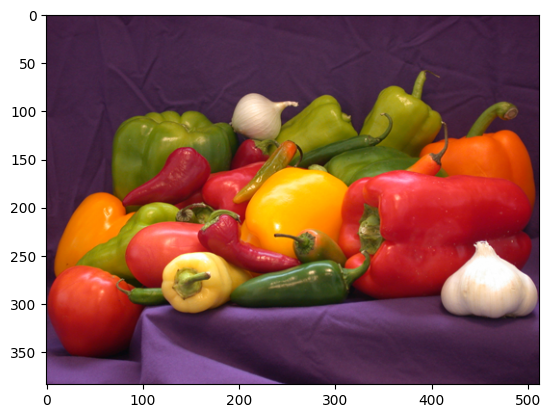

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision

# Download an example image
!wget -q http://www.di.ens.fr/willow/teaching/recvis_orig/assignment3/images/peppers.png
# Read the image
x = np.asarray(Image.open('peppers.png'))/255.0
# Print the size of x. Third dimension (=3) corresponds to the R, G, B channels
print(x.shape)
# Visualize the input x
plt.imshow(x)
# Convert to torch tensor
x = torch.from_numpy(x).permute(2, 0, 1).float()
print(x.shape)
# Prepare it as a batch
x = x.unsqueeze(0)

In [26]:
# Create a convolutional layer and a random bank of linear filters
conv = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=0, bias=False)
print(conv.weight.size())

torch.Size([10, 3, 5, 5])


**Remark:** You might have noticed that the `bias` argument to the `torch.nn.Conv2d` function is the empty matrix `false`. It can be otherwise used to pass a vector of bias terms to add to the output of each filter.

Note that `conv.weight` has four dimensions, packing 10 filters. Note also that each filter is not flat, but rather a volume containing three slices. The next step is applying the filter to the image.

In [17]:
# Apply the convolution operator
y = conv(x)
# Observe the input/output sizes
print(x.size())
print(y.size())

torch.Size([1, 3, 384, 512])
torch.Size([1, 2, 382, 512])


The variable `y` contains the output of the convolution. Note that the filters are three-dimensional. This is because they operate on a tensor $\mathbf{x}$ with $K$ channels. Furthermore, there are $K'$ such filters, generating a $K'$ dimensional map $\mathbf{y}$.

We can now visualise the output `y` of the convolution. In order to do this, use the `torchvision.utils.make_grid` function to display an image for each feature channel in `y`:

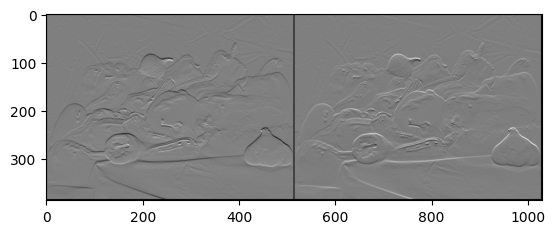

In [18]:
# Visualize the output y
def vis_features(y):
    # Organize it into 10 grayscale images
    out = y.permute(1, 0, 2, 3)
    # Scale between [0, 1]
    out = (out - out.min().expand(out.size())) / (out.max() - out.min()).expand(out.size())
    # Create a grid of images
    out = torchvision.utils.make_grid(out, nrow=5)
    # Convert to numpy image
    out = np.transpose(out.detach().numpy(), (1, 2, 0))
    # Show
    plt.imshow(out)
    # Remove grid
    plt.gca().grid(False)

vis_features(y)

So far filters preserve the resolution of the input feature map. However, it is often useful to *downsample the output*. This can be obtained by using the `stride` option in `torch.nn.Conv2d`:

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 24, 32])


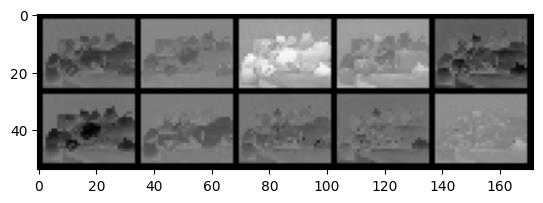

In [19]:
# Try again, downsampling the output
conv_ds = torch.nn.Conv2d(3, 10, kernel_size=5, stride=16, padding=0, bias=False)
y_ds = conv_ds(x)
print(x.size())
print(y_ds.size())
vis_features(y_ds)

Applying a filter to an image or feature map interacts with the boundaries, making the output map smaller by an amount proportional to the size of the filters. If this is undesirable, then the input array can be padded with zeros by using the `pad` option:

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 384, 512])


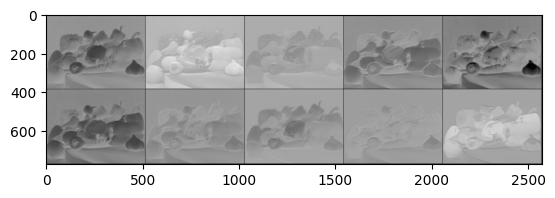

In [20]:
# Try padding
conv_pad = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2, bias=False)
y_pad = conv_pad(x)
print(x.size())
print(y_pad.size())
vis_features(y_pad)

In order to consolidate what has been learned so far, we will now design a filter by hand:


torch.Size([1, 3, 384, 512])
torch.Size([1, 1, 384, 512])


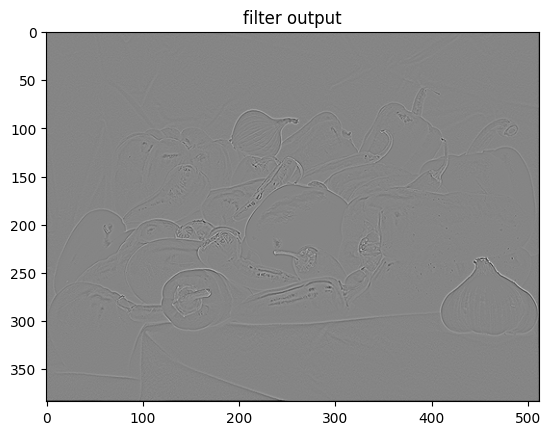

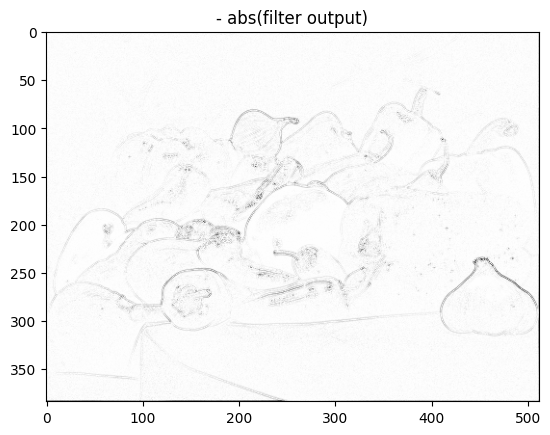

In [21]:
w = torch.FloatTensor([[0,  1, 0 ],
                      [1, -4, 1 ],
                      [0,  1, 0 ]])
w = w.repeat(3, 1).reshape(1, 3, 3, 3)
conv_lap = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)
conv_lap.weight = torch.nn.Parameter(w)
y_lap = conv_lap(x)
print(x.size())
print(y_lap.size())

plt.figure()
vis_features(y_lap)
plt.title('filter output')

plt.figure()
vis_features(-torch.abs(y_lap))
plt.title('- abs(filter output)') ;

**Q1 : What filter have we implemented? How are the RGB colour channels processed by this filter? What image structure are detected?**

*Intrepretation *

*We implement 2d filter and The RGB color channels are processed independently by this filter. Each channel is convolved with the kernel separately, and the results are combined to form the output feature map.*


## Non-linear activation functions

The simplest non-linearity is obtained by following a linear filter by a *non-linear activation function*, applied identically to each component (i.e. point-wise) of a feature map. The simplest such function is the *Rectified Linear Unit (ReLU)*
$$
  y_{ijk} = \max\{0, x_{ijk}\}.
$$
This function is implemented by [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU). Run the code below and understand what the filter $\mathbf{w}$ is doing.


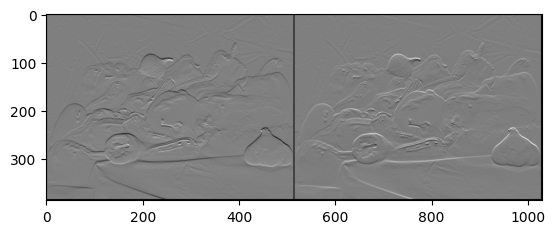

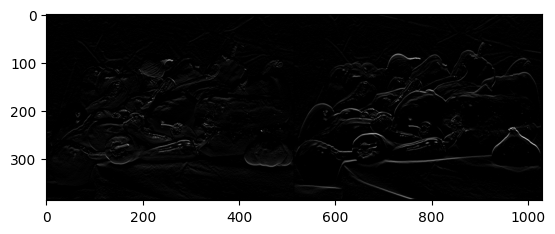

In [23]:
w = torch.FloatTensor([[1], [0], [-1]]).repeat(1, 3, 1, 1)
w = torch.cat((w, -w), 0)

conv = torch.nn.Conv2d(3, 2, kernel_size=(3, 1), stride=1, padding=0, bias=False)
conv.weight = torch.nn.Parameter(w)
relu = torch.nn.ReLU()

y = conv(x)
z = relu(y)

plt.figure()
vis_features(y)
plt.figure()
vis_features(z)

## Pooling
There are several other important operators in a CNN. One of them is *pooling*.  A pooling operator operates on individual feature channels, coalescing nearby feature values into one by the application of a suitable operator. Common choices include max-pooling (using the max operator) or sum-pooling (using summation). For example, *max-pooling* is defined as:
$$
   y_{ijk} = \max \{ y_{i'j'k} : i \leq i' < i+p, j \leq j' < j + p \}
$$
Max-pooling is implemented by [`torch.nn.MaxPool2d()`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d).

**Q2 : Run the code below to try max-pooling. Look at the resulting image. Can you interpret the result?**

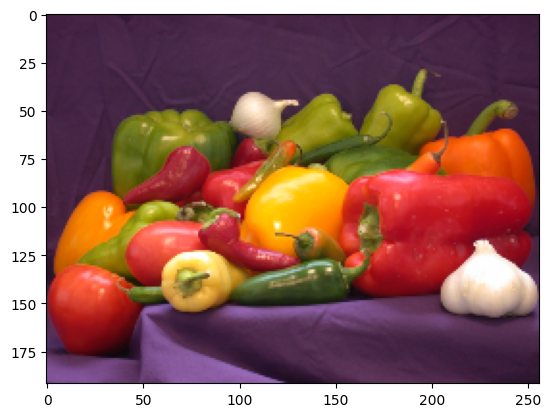

In [33]:
mp = nn.MaxPool2d(kernel_size=2, stride=2)
y = mp(x)
plt.imshow(y.squeeze().permute(1, 2, 0).numpy())
plt.gca().grid(False)

### **Interpretation **
Max-pooling with a kernel size of 2x2 and a stride of 3 reduces the spatial dimensions of the input tensor significantly.
Our stride is 3, the pooling operation skips every two pixels in both height and width directions.
The resulting image will have reduced dimensions compared to the original input image. *texte en italique*

# Part 2 - Training a CNN

This part is an introduction to using PyTorch for training simple neural net models. CIFAR-10 dataset will be used.

In [34]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [35]:
#Default values for learning

batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01         # learning rate

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
The train/test split is 50k/10k.

In [38]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time,
#          because it will download the dataset from the internet
dataset = 'cifar10'
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


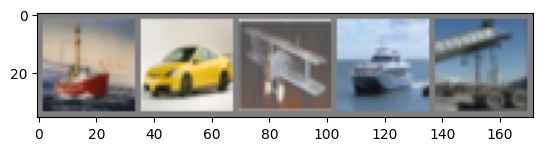

ship  car   plane ship  truck


In [39]:
import matplotlib.pyplot as plt
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=0)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

## Training a Convolutional Network on CIFAR-10

Start by running the provided training code below. By default it will train on CIFAR-10 for 10 epochs (passes through the training data) with a single layer network. The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`. Note the decrease in training loss and corresponding decrease in validation errors.

In [40]:
def train(epoch, network):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [41]:
# Single layer network architecture

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.num_inputs = num_inputs

    def forward(self, input):
        input = input.view(-1, self.num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

In [42]:
# Train
network = Net(3072, 10)
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 11):
    train(epoch, network)
    test(network)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.359428
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.842264
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.996544
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.869084
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.767062
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.855082
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.773789
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.664588


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.8025, Accuracy: 3653/10000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.963463
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.622748
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.749738
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.829267
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.605223
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.863497
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.697680
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.623196

Test set: Average loss: 1.7496, Accuracy: 3954/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.792680
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.695314
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.644287
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.732086
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.681991
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.768055
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.960742
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.842404

Test set: Average loss: 1.7498, Accuracy: 3936/10000 (39%)

Train Epoch: 4 [0/50000 (0%)]

**Q3 : Add code to create a convolutional network architecture as below.**

  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        #CODE HERE

    def forward(self, input):

        #CODE HERE

        return output



**Q4 : Some of the functions in a CNN must be non-linear. Why?**

**Q5 : Train the CNN for 20 epochs on the CIFAR-10 training set using SGD optimizer.**

In [ ]:
# Train
network = #CODE
optimizer = #CODE

In [ ]:
#Plot the first convolutional layer weights as images after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt


def vistensor(tensor, ch=0, allkernels=False, nCol=8, padding=1):


    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    Col = np.min( (tensor.shape[0]//nCol + 1, 64 )  )
    grid = utils.make_grid(tensor, nCol=nCol, normalize=True, padding=padding)
    plt.figure( figsize=(nCol,Col) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

tensor = network.Conv1.weight
print(tensor.shape)

vistensor(tensor, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

**Q6 : What is the dimensionality of the weights at each layer? How many parameters are there in total in this CNN architecture?**

# Part 3 - GAN

In [ ]:
# torch stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# torchsummary and torchvision
from torchsummary import summary
from torchvision.utils import save_image

# matplotlib stuff
import matplotlib.pyplot as plt
import matplotlib.image as img

# numpy and pandas
import numpy as np
import pandas as pd

# Common python packages
import datetime
import os
import sys
import time

In this part we will focus on **image synthesis**, in particular to
synthesize **T2-weighted MRI** from **T1-weighted MRI**.

We will investigate two approaches to do so:

1. First, we will train a generator (or encoder-decoder).
3. Then, we will train a cycle generative adversarial network (CycleGAN).

We will evaluate the quality of the generated images using several metrics.

We will use the [IXI dataset](https://brain-development.org/ixi-dataset/)
to have access to **paired T1-w and T2-w images**.
Before creating and training the different neural networks,
we will:

1. fetch the dataset,
2. have a look at it to see what the task looks like, and
3. illustrate how to easily access the data.

The dataset can be found on this
[server](https://aramislab.paris.inria.fr/files/data/databases/DL4MI/IXI-dataset.tar.gz)
and alternatively in the following
[GitHub repository](https://github.com/Easternwen/IXI-dataset).
In the `size64` folder, there are 1154 files: 2 images for 577 subjects.
The size of each image is (64, 64).

Let's download the file and have a look at the data.

In [ ]:
# Get the dataset from the server
! git clone https://github.com/Easternwen/IXI-dataset.git

The dataset used in this lab is composed of preprocessed images from the
[IXI dataset](https://brain-development.org/ixi-dataset/). Two different
structural MRI modalities are comprised in this dataset:

- T1 weighted images

- T2 weighted images

These modalities do not highlight the same tissues: for example the CSF
voxels are cancelled in T1 weighted imaging whereas they are highlighted by
the T2 weighted imaging.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch


root = "./IXI-dataset/size64/"

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.swapaxes(torch.load(os.path.join(root, 'sub-IXI002 - T1.pt')), 0, 1),
           cmap='gray', origin='lower')
plt.title("T1 slice for subject 002")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.swapaxes(torch.load(os.path.join(root, 'sub-IXI002 - T2.pt')), 0, 1),
           cmap='gray', origin='lower')
plt.title("T2 slice for subject 002")
plt.axis('off')
plt.show()

Let's create a custom `IXIDataset` class to easily have access to the data.

Here we don't use tsv files to split subjects between the training and the
test set. We only set the dataset to the `train` or `test` mode to access
training or test data.

**Q7 : Complete de IXIDataset class**

In [ ]:
class IXIDataset(torch.utils.data.Dataset):
    """Dataset utility class.

    Args:
        root: (str) Path of the folder with all the images.
        mode : {'train' or 'test'} Part of the dataset that is loaded.

    """
    def __init__(self, root, mode="train"):

        files = sorted(os.listdir(root))
        patient_id = list(set([i.split()[0] for i in files]))

        imgs = []

        if mode == "train":
            for i in patient_id[:int(0.8 * len(patient_id))]:
                if (
                    os.path.isfile(os.path.join(root, i + " - T1.pt")) and
                    os.path.isfile(os.path.join(root, i + " - T2.pt"))
                ):
                    imgs.append((os.path.join(root, i + " - T1.pt"),
                                 os.path.join(root, i + " - T2.pt")))

        elif mode == "test":
            #CODE HERE

        self.imgs = imgs

    def __getitem__(self, index):
        t1_path, t2_path = self.imgs[index]

        t1 = torch.load(t1_path)[None, :, :]
        t2 = torch.load(t2_path)[None, :, :]

        return {"T1": t1, "T2": t2}

    def __len__(self):
        return # CODE HERE

Using this class and the `DataLoader` class from `torch.utils.data`, you can
easily have access to your dataset. Here is a quick example on how to use it:

```python
# Create a DataLoader instance for the training set
# You will get a batch of samples from the training set
dataloader = DataLoader(
    IXIDataset(root, mode="train"),
    batch_size=1,
    shuffle=False,
)

for batch in dataloader:
    # batch is a dictionary with two keys:
    # - batch["T1"] is a tensor with shape (batch_size, 64, 64) with the T1 images for the samples in this batch
    # - batch["T2"] is a tensor with shape (batch_size, 64, 64) with the T2 images for the samples in this batch
```

## Generator

In this section we use a generator to generate T2w images corresponding to T1w images.
We can use this framework because we have a dataset of paired data.

The generator will have a **U-Net architecture** with the following
characteristics:

* the descending blocks are convolutional layers followed by instance
  normalization with a ReLU activation function;

* the ascending blocks are transposed convolutional layers followed by
  instance normalization with a ReLU activation function.

The parameters for each layer are given in the picture below.

If a layer takes two different feature maps as input they are concatenated.

<img src="/content/UNet_image.png">

In [ ]:
# We provide classes for each block of the U-Net.

class UNetDown(nn.Module):
    """Descending block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(UNetDown, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU()
          )

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    """Ascending block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=4,
                               stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU()
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x


class FinalLayer(nn.Module):
    """Final block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(FinalLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)

        self.up1 = UNetUp(512, 512)
        self.up2 = UNetUp(1024, 256)
        self.up3 = UNetUp(512, 128)
        self.up4 = UNetUp(256, 64)

        self.final = FinalLayer(128, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u1 = self.up1(d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)

        return self.final(u4, d1)

In [ ]:
# Summary of the generator
summary(GeneratorUNet().cuda(), (1, 64, 64) )

### Train the generator

The loss function for this task is the expected value of the pixel-wise mean absolute error between the true T2 image, denoted $X_{T2}$, and the generated T2 image from the T1 image, denoted $G(X_{T1})$, that is $L_1$-norm of the difference between both images:

$$
\mathcal{L}(G) = \mathbb{E}\left[ \Vert X_{T2} - G(X_{T1}) \Vert_1 \right]
$$

In order to train the generator, we will repeat the following process:

1. Generate T2-w images from T1-w images.
2. Compute the error between the true T2-w images and the generated T2-w images.
3. Update the parameters of the generator.

The training phase looks like this:

```
# For each epoch

    # For each batch

        # Generate fake images for all the images in this batch

        # Compute the loss for the generator

        # Perform one optimization step
```

**Q8 : We provide below a template to train our generator
 on the dataset. Fill in the missing parts.**

In [ ]:
def train_generator(train_loader, test_loader, num_epoch=500,
                    lr=0.0001, beta1=0.9, beta2=0.999):
    """Train a generator on its own.

    Args:
        train_loader: (DataLoader) a DataLoader wrapping the training dataset
        test_loader: (DataLoader) a DataLoader wrapping the test dataset
        num_epoch: (int) number of epochs performed during training
        lr: (float) learning rate of the discriminator and generator Adam optimizers
        beta1: (float) beta1 coefficient of the discriminator and generator Adam optimizers
        beta2: (float) beta1 coefficient of the discriminator and generator Adam optimizers

    Returns:
        generator: (nn.Module) the trained generator
    """

    cuda = True if torch.cuda.is_available() else False
    print(f"Using cuda device: {cuda}")  # check if GPU is used

    # Tensor type (put everything on GPU if possible)
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    # Output folder
    if not os.path.exists("./images/generator"):
        os.makedirs("./images/generator")

    # Loss function
    criterion = # CODE HERE A loss for a voxel-wise comparison of images

    # Initialize the generator
    generator = GeneratorUNet()

    if cuda:
        generator = generator.cuda()
        criterion.cuda()

    # Optimizer
    optimizer = torch.optim.Adam(generator.parameters(),
                                 lr=lr, betas=(beta1, beta2))

    def sample_images(epoch):
        """Saves a generated sample from the validation set"""
        imgs = next(iter(test_loader))
        real_A = imgs["T1"].type(Tensor)
        real_B = imgs["T2"].type(Tensor)
        fake_B = generator(real_A)
        img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
        save_image(img_sample, f"./images/generator/epoch-{epoch}.png",
                   nrow=5, normalize=True)

    # ----------
    #  Training
    # ----------

    prev_time = time.time()

    for epoch in range(num_epoch):
        for i, batch in enumerate(train_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)

            # Remove stored gradients
            optimizer.zero_grad()

            # Generate fake T2 images from the true T1 images
            # CODE HERE

            # Compute the corresponding loss
            # CODE HERE

            # Compute the gradient and perform one optimization step
            loss.backward()
            optimizer.step()

            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(train_loader) + i
            batches_left = num_epoch * len(train_loader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f] ETA: %s"
                % (
                    epoch + 1,
                    num_epoch,
                    i,
                    len(train_loader),
                    loss.item(),
                    time_left,
                )
            )

        # Save images at the end of each epoch
        sample_images(epoch)

    return generator

In [ ]:
# Parameters for Adam optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create dataloaders
batch_size = 40
train_loader = DataLoader(IXIDataset(root, mode="train"),
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(IXIDataset(root, mode="test"),
                         batch_size=5,
                         shuffle=False)

# Number of epochs
num_epoch = 20

# Train the generator
generator = train_generator(train_loader, test_loader, num_epoch=num_epoch,
                            lr=lr, beta1=beta1, beta2=beta2)

### Evaluate the generator

Let's visualize a few generated T2-weighted images:

In [ ]:
im = img.imread(f'./images/generator/epoch-{num_epoch - 1}.png')
plt.figure(figsize=(20, 20))
plt.imshow(np.swapaxes(im, 0, 1))
plt.gca().invert_yaxis()
plt.text(32, 334, 'Original T1 image', ha='center', fontsize=16)
plt.text(96, 334, 'Generated T2 image', ha='center', fontsize=16)
plt.text(160, 334, 'Original T2 image', ha='center', fontsize=16)
plt.axis('off')
plt.show()

After doing visual quality control, it is a good idea to quantify the quality
of the generated images using specific metrics. Some popular metrics include
the Mean Absolute Error (MAE), the Peak Signal-to-Noise Ratio (PSNR) and
the Structural Similarity index (SSIM):

* MAE = $\displaystyle \frac{1}{nm} \sum_{i=1}^n \sum_{j=1}^m \vert T_{ij} - G_{ij} \vert $

* PSNR = $\displaystyle -10 \log_{10} \left( \frac{1}{nm} \sum_{i=1}^n \sum_{j=1}^m (T_{ij} - G_{ij})^2 \right) $

* SSIM = $\displaystyle  \frac{(2 \mu_T \mu_G + C_1)(2 \sigma_{TG} + C_2)}{(\mu_T^2 +
\mu_G^2 + C_1)(\sigma_T^2 + \sigma_G^2 + C_2)} $ where:

    * $\mu$ and $\sigma$ are the mean value and standard deviation of an image respectively, and
    * $C_1$ and $C_2$ are two positive constants (one can take $C_1=0.01$ and $C_2=0.03$).

The [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)
is simply the mean of each absolute value of the difference between
the true pixel ($T_{ij}$) and the generated pixel ($G_{ij}$).
The lower, the better. Minimum value is 0.

The [peak signal-to-noise ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
is a function of the mean squared error and allows for comparing
images encoded with different scales. We simplified its formula in our case.
The higher, the better. Maximum value is $+\infty$.

The [structural similarity index](https://en.wikipedia.org/wiki/Structural_similarity)
is a weighted combination of the luminance, the contrast and the structure.
The higher, the better. Maximum value is 1.

For those interested, you can find [here](https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/)
a reference to better understand the differences between these metrics.

A good practice is to use existing implementations:
* [sklearn.metrics.mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)
* [skimage.metrics.peak_signal_noise_ratio](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.peak_signal_noise_ratio)
* [skimage.metrics.structural_similarity](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity)

The code below is given as an example so that you can get an idea of how it is computed.

In [ ]:
def mean_absolute_error(image_true, image_generated):
    """Compute mean absolute error.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image

    Returns:
        mse: (float) mean squared error
    """
    return torch.abs(image_true - image_generated).mean()


def peak_signal_to_noise_ratio(image_true, image_generated):
    """"Compute peak signal-to-noise ratio.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image

    Returns:
        psnr: (float) peak signal-to-noise ratio"""
    mse = ((image_true - image_generated) ** 2).mean().cpu()
    return -10 * np.log10(mse)


def structural_similarity_index(image_true, image_generated, C1=0.01, C2=0.03):
    """Compute structural similarity index.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
        C1: (float) variable to stabilize the denominator
        C2: (float) variable to stabilize the denominator

    Returns:
        ssim: (float) mean squared error"""
    mean_true = image_true.mean()
    mean_generated = image_generated.mean()
    std_true = image_true.std()
    std_generated = image_generated.std()
    covariance = (
        (image_true - mean_true) * (image_generated - mean_generated)).mean()

    numerator = (2 * mean_true * mean_generated + C1) * (2 * covariance + C2)
    denominator = ((mean_true ** 2 + mean_generated ** 2 + C1) *
                   (std_true ** 2 + std_generated ** 2 + C2))
    return numerator / denominator

To better understand the SSIM metric, we can plot a local computation of each component of this metric: luminance, contrast and structure.


In [ ]:
def luminance(image_true, image_generated, C1=0.01):
    """Compute structural similarity index.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
        C1: (float) variable to stabilize the denominator

    Returns:
        ssim: (float) mean squared error"""
    mean_true = image_true.mean()
    mean_generated = image_generated.mean()

    numerator = (2 * mean_true * mean_generated + C1)
    denominator = (mean_true ** 2 + mean_generated ** 2 + C1)
    return numerator / denominator

def contrast(image_true, image_generated, C2=0.03):
    """Compute structural similarity index.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
        C2: (float) variable to stabilize the denominator

    Returns:
        ssim: (float) mean squared error"""
    std_true = image_true.std()
    std_generated = image_generated.std()

    numerator = 2 * std_true * std_generated + C2
    denominator = std_true ** 2 + std_generated ** 2 + C2
    return numerator / denominator

def structure(image_true, image_generated, C3=0.015):
    """Compute structural similarity index.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
        C3: (float) variable to stabilize the denominator

    Returns:
        ssim: (float) mean squared error"""
    mean_true = image_true.mean()
    mean_generated = image_generated.mean()
    std_true = image_true.std()
    std_generated = image_generated.std()
    covariance = (
        (image_true - mean_true) * (image_generated - mean_generated)).mean()

    numerator = covariance + C3
    denominator = std_true * std_generated + C3
    return numerator / denominator

def generate_fn_map(image_true, image_generated, metric_fn, patch_size=5):
    """
    Compute a metric locally (in a sliding window of patch_size x patch_size)

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
        metric_fn: (callable) method applied to patches
        patch_size: (int) size of the sliding window
    """
    metric_map = torch.zeros((image_true.size(0) - patch_size,
                              image_true.size(1) - patch_size))
    for i in range(image_true.size(0) - patch_size):
        for j in range(image_true.size(1) - patch_size):
            patch_true = image_true[i:i+patch_size, j:j+patch_size]
            patch_generated = image_generated[i:i+patch_size, j:j+patch_size]
            metric_map[i, j] = metric_fn(patch_true, patch_generated)

    return metric_map

In [ ]:
# Load example subject
t1_pt = torch.load(os.path.join(root, 'sub-IXI002 - T1.pt'))
t2_pt = torch.load(os.path.join(root, 'sub-IXI002 - T2.pt'))

plt.figure(figsize=(12, 9))

plt.subplot(1, 2, 1)
plt.imshow(np.swapaxes(t1_pt, 0, 1),
           cmap='gray', origin='lower')
plt.title("T1w image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.swapaxes(t2_pt, 0, 1),
           cmap='gray', origin='lower')
plt.title("T2w image")
plt.axis('off')
plt.show()

In [ ]:
# Generate maps
luminance_t1_t2 = generate_fn_map(t1_pt, t2_pt, luminance)
contrast_t1_t2 = generate_fn_map(t1_pt, t2_pt, contrast)
structure_t1_t2 = generate_fn_map(t1_pt, t2_pt, structure)

# Plot with matplotlib
plt.figure(figsize=(12, 9))

plt.subplot(1, 3, 1)
plt.imshow(np.swapaxes(luminance_t1_t2, 0, 1),
           cmap='gray', origin='lower')
plt.title("Luminance T1/T2")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.swapaxes(contrast_t1_t2, 0, 1),
           cmap='gray', origin='lower')
plt.title("Contrast T1/T2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.swapaxes(structure_t1_t2, 0, 1),
           cmap='gray', origin='lower')
plt.title("Structure T1/T2")
plt.axis('off')
plt.show()

We will now evaluate the generator with these three metrics on both the
training set and the test set by computing the mean value for each metric.

In [ ]:
def evaluate_generator(generator):
    """Evaluate a generator.

    Args:
        generator: (GeneratorUNet) neural network generating T2-w images

    """
    res_train, res_test = [], []

    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    with torch.no_grad():

        for i, batch in enumerate(train_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)
            fake_t2 = generator(real_t1)

            mae = mean_absolute_error(real_t2, fake_t2).item()
            psnr = peak_signal_to_noise_ratio(real_t2, fake_t2).item()
            ssim = structural_similarity_index(real_t2, fake_t2).item()

            res_train.append([mae, psnr, ssim])

        for i, batch in enumerate(test_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)
            fake_t2 = generator(real_t1)

            mae = mean_absolute_error(real_t2, fake_t2).item()
            psnr = peak_signal_to_noise_ratio(real_t2, fake_t2).item()
            ssim = structural_similarity_index(real_t2, fake_t2).item()

            res_test.append([mae, psnr, ssim])

        df = pd.DataFrame([
            pd.DataFrame(res_train, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze(),
            pd.DataFrame(res_test, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze()
        ], index=['Training set', 'Test set']).T
    return df

In [ ]:
evaluate_generator(generator)

In [ ]:
#@title
%%html
<div style='background-color:rgba(80,255,80,0.4); padding:20px'>
  <p><b>Note</b>: </p>
  <p>In this section we did not use an adversarial setting to generate the images.
    You can try to add a discriminator to improve the performance if you want!
  </p>
</div>

## CycleGAN

A cycle generative adversarial network (CycleGAN) is a technique for training
**unsupervised image translation** models via the GAN architecture using
unpaired collections of images from two different domains.
The main innovation of a CycleGAN is to introduce a
**cycle consistency loss** to enforce good reconstruction in both domains.

A CycleGAN consists of two GAN:

* one generating samples from domain *A* to domain *B*, and

* another one generating from domain *B* to domain *A*.

The cycle consistency consists in generating from one domain to the other
domain then generating back from the second domain to the first domain, and
comparing the generated sample from the original sample.
The image below (taken from the [original paper introducing CycleGAN](https://arxiv.org/pdf/1703.10593.pdf))
summarizes the main concepts of a CycleGAN:

Each GAN will have the same architecture:
* For the generators, we will use the `GeneratorUNet` architecture that
  you already implemented.
* For the discriminators, we will use a simple CNN whose architecture
  is depicted below.

<div class="alert alert-block alert-info">
  <b>Exercise</b>: Create a <code>Discriminator</code> class to define the
  discriminator with the architecture given above.
</div>

In [ ]:
# We provide a function to generate a block for the given architecture.
def discriminator_block(in_filters, out_filters):
    """Return downsampling layers of each discriminator block"""
    layers = [nn.Conv2d(in_filters, out_filters, 3, stride=2, padding=1)]
    layers.append(nn.LeakyReLU())
    return layers


class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()

        layers = []
        layers.extend(discriminator_block(in_channels, 64))
        layers.extend(discriminator_block(64, 128))
        layers.extend(discriminator_block(128, 256))
        layers.extend(discriminator_block(256, 512))
        layers.append(nn.Conv2d(512, 1, 4, padding=0))
        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [ ]:
# Summary of one discriminator in the CycleGAN
summary(Discriminator().cuda(), (1, 64, 64))

### Training the CycleGAN

Now that we have coded classes for our generators and our discriminators,
we have to train them on the dataset.

We will use two colors to make the content more clear:

* $\color{orange}{\text{images in T1 domain and their related probabilities are highlighted in orange}} ;$

* $\color{blue}{\text{images in the T2 domain and their related probabilities are highlighted in blue}} .$

**Notations**

True images:
* $\color{orange}{X_{T1}}$: true T1 image;
* $\color{blue}{X_{T2}}$: true T2 image;

GAN from T1 to T2:
* $G_{T1 \rightarrow T2}$: generator from T1 to T2;
* $D_{T2}$: discriminator for T2 domain;

GAN from T2 to T1:
* $G_{T2\rightarrow T1}$: generator from T2 to T1;
* $D_{T1}$: discriminator for T1 domain;

Generated images:
* $\color{blue}{X_{T1 \rightarrow T2}} = G_{T1 \rightarrow T2}(\color{orange}{X_{T1}})$: generated T2 image from $\color{orange}{X_{T1}}$;
* $\color{orange}{X_{T2 \rightarrow T1}} = G_{T2 \rightarrow T1}(\color{blue}{X_{T2}})$: generated T1 image from $\color{blue}{X_{T2}}$;
* $\color{orange}{X_{T1 \rightarrow T2 \rightarrow T1}} = G_{T2 \rightarrow T1}(\color{blue}{X_{T1 \rightarrow T2}}) = G_{T2 \rightarrow T1}(G_{T1 \rightarrow T2}(\color{orange}{X_{T1}}))$: generated T1 image from $\color{blue}{X_{T1 \rightarrow T2}}$;
* $\color{blue}{X_{T2 \rightarrow T1 \rightarrow T2}} = G_{T1 \rightarrow T2}(\color{orange}{X_{T2 \rightarrow T1}}) = G_{T1 \rightarrow T2}(G_{T2 \rightarrow T1}(\color{blue}{X_{T2}}))$: generated T2 image from $\color{orange}{X_{T2 \rightarrow T1}}$;

Probabilities:
* $\color{orange}{\hat{y}_{X_{T1}}} = D_{T1}(\color{orange}{X_{T1}})$: probability returned by $D_{T1}$ that $\color{orange}{X_{T1}}$ is real;
* $\color{blue}{\hat{y}_{X_{T2}}} = D_{T2}(\color{blue}{X_{T2}})$: probability returned by $D_{T2}$ that $\color{blue}{X_{T2}}$ is real;
* $\color{orange}{\hat{y}_{X_{T2 \rightarrow T1}}} = D_{T1}(\color{orange}{X_{T2 \rightarrow T1}})$: probability returned by $D_{T1}$ that $\color{orange}{X_{T2 \rightarrow T1}}$ is real;
* $\color{blue}{\hat{y}_{X_{T1 \rightarrow T2}}} = D_{T2}(\color{blue}{X_{T1 \rightarrow T2}})$: probability returned by $D_{T2}$ that $\color{blue}{X_{T1 \rightarrow T2}}$ is real;

**Loss function**

The loss function of a CycleGAN consists of three terms:

* the adversarial loss for the first GAN $(G_{T1 \rightarrow T2}, D_{T2})$: $$ \mathcal{L}_{\text{GAN}}(G_{T1 \rightarrow T2}, D_{T2}) = \mathbb{E}\left[ \log(\color{blue}{\hat{y}_{X_{T2}}}) \right] + \mathbb{E}\left[ \log(1 - \color{blue}{\hat{y}_{X_{T1 \rightarrow T2}}}) \right] $$

* the adversarial loss for the second GAN $(G_{T2 \rightarrow T1}, D_{T1})$: $$ \mathcal{L}_{\text{GAN}}(G_{T2 \rightarrow T1}, D_{T1}) = \mathbb{E}\left[ \log(\color{orange}{\hat{y}_{X_{T1}}}) \right] + \mathbb{E}\left[ \log(1 - \color{orange}{\hat{y}_{X_{T2 \rightarrow T1}}}) \right] $$

* the cycle consistency loss: $$ \mathcal{L}_{\text{cyc}}(G_{T1 \rightarrow T2}, G_{T2 \rightarrow T1}) = \mathbb{E}\left[ \Vert \color{blue}{X_{T2 \rightarrow T1 \rightarrow T2}} - \color{blue}{X_{T2}} \Vert_1 \right] + \mathbb{E}\left[ \Vert \color{orange}{X_{T1 \rightarrow T2 \rightarrow T1}} - \color{orange}{X_{T1}} \Vert_1 \right] $$

The total loss is a weighted linear combination of these three terms:
$$
\mathcal{L}(G_{T1 \rightarrow T2}, G_{T2 \rightarrow T1}, D_{T2}, D_{T1}) =
\mathcal{L}_{\text{GAN}}(G_{T1 \rightarrow T2}, D_{T2}) +
\mathcal{L}_{\text{GAN}}(G_{T2 \rightarrow T1}, D_{T1}) +
\lambda \times \mathcal{L}_{\text{cyc}}(G_{T1 \rightarrow T2}, G_{T2 \rightarrow T1})
$$

The generators try to minimize this function, while the discriminators try to maximize it:
$$
\min_{G_{T1 \rightarrow T2}, G_{T2 \rightarrow T1}} \max_{D_{T2}, D_{T1}} \mathcal{L}(G_{T1 \rightarrow T2}, G_{T2 \rightarrow T1}, D_{T2}, D_{T1})
$$

To solve this optimization problem, we will alternate between minimizing with regards to the generators and maximizing with regards to the discriminators.

**Training the generators**

The generators want to fool the discriminators (generated images classified as true images) and have a good cycle consistency together.
In both GAN losses, the first term is the binary cross-entropy loss corresponding to the the probability returned by the discriminator for a true image is indeed a true image. This term does not depend on the generators and can thus be dropped.

The loss for the generators is:
$$
\mathcal{L}(G_{T1 \rightarrow T2}, G_{T2 \rightarrow T1}) =
\mathbb{E}\left[ \log(1 - \color{blue}{\hat{y}_{X_{T1 \rightarrow T2}}}) \right] +
\mathbb{E}\left[ \log(1 - \color{orange}{\hat{y}_{X_{T2 \rightarrow T1}}}) \right] +
\lambda \times \mathbb{E}\left[ \Vert \color{blue}{X_{T2 \rightarrow T1 \rightarrow T2}} - \color{blue}{X_{T2}} \Vert_1 \right]
+ \lambda \times \mathbb{E}\left[ \Vert \color{orange}{X_{T1 \rightarrow T2 \rightarrow T1}} - \color{orange}{X_{T1}} \Vert_1 \right]
$$

For one sample, it is then:

$$
\mathcal{L}(G_{T1 \rightarrow T2}, G_{T2 \rightarrow T1}) =
\log(1 - \color{blue}{\hat{y}_{X_{T1 \rightarrow T2}}}) +
\log(1 - \color{orange}{\hat{y}_{X_{T2 \rightarrow T1}}}) +
\lambda \times \Vert \color{blue}{X_{T2 \rightarrow T1 \rightarrow T2}} - \color{blue}{X_{T2}} \Vert_1 +
\lambda \times \Vert \color{orange}{X_{T1 \rightarrow T2 \rightarrow T1}} - \color{orange}{X_{T1}} \Vert_1
$$

**Training the discriminators**

The discriminators want to accurately discriminate true and fake images.
The cycle-consistency loss does not depend on the discriminators and can thus be dropped.

The loss for the discriminators is:
$$
\mathcal{L}(D_{T2}, D_{T1}) =
\mathbb{E}\left[ \log(\color{blue}{\hat{y}_{X_{T2}}}) \right] +
\mathbb{E}\left[ \log(1 - \color{blue}{\hat{y}_{X_{T1 \rightarrow T2}}}) \right] +
\mathbb{E}\left[ \log(\color{orange}{\hat{y}_{X_{T1}}}) \right] +
\mathbb{E}\left[ \log(1 - \color{orange}{\hat{y}_{X_{T2 \rightarrow T1}}}) \right]
$$

Remember that the discriminators want to **maximize** this quantity. To have a minimization problem, you just have to multiply the loss by $-1$:
$$
- \mathcal{L}(D_{T2}, D_{T1}) =
- \mathbb{E}\left[ \log(\color{blue}{\hat{y}_{X_{T2}}}) \right] -
\mathbb{E}\left[ \log(1 - \color{blue}{\hat{y}_{X_{T1 \rightarrow T2}}}) \right] -
\mathbb{E}\left[ \log(\color{orange}{\hat{y}_{X_{T1}}}) \right] -
\mathbb{E}\left[ \log(1 - \color{orange}{\hat{y}_{X_{T2 \rightarrow T1}}}) \right]
$$


For one sample, it is then:

$$
- \mathcal{L}(D_{T2}, D_{T1}) =
- \log(\color{blue}{\hat{y}_{X_{T2}}}) -
\log(1 - \color{blue}{\hat{y}_{X_{T1 \rightarrow T2}}}) -
\log(\color{orange}{\hat{y}_{X_{T1}}}) -
\log(1 - \color{orange}{\hat{y}_{X_{T2 \rightarrow T1}}})
$$

**Training phase**

The generators and the discriminators are trained simultaneously, which makes
the training phase look like this:

```
# For each epoch

    # For each batch

        # Generators

        ## Generate fake T2-weighted images for all the T1-weighted images in this batch
        
        ## Generate fake T1-weighted images for all the T2-weighted images in this batch

        ## Generate fake T1-weighted images for all the fake generated T2-weighted images in this batch
        
        ## Generate fake T2-weighted images for all the fake generated T1-weighted images in this batch

        ## Compute the loss for both generators and perform one optimization step

        # Discriminators

        ## Generate fake T1-weighted images for all the T2-weighted images in this batch

        ## Generate fake T2-weighted images for all the fake generated T1-weighted images in this batch

        ## Compute the loss for both discriminators and perform one optimization step
```

**Q9 : We provide below a template to train our cycle GAN on the dataset. Fill in the missing parts.**

In [ ]:
def train_cyclegan(train_loader, test_loader, num_epoch=500,
                   lr=0.0001, beta1=0.9, beta2=0.999):
    """Train a CycleGAN.

    Args:
        train_loader: (DataLoader) a DataLoader wrapping a the training dataset
        test_loader: (DataLoader) a DataLoader wrapping a the test dataset
        num_epoch: (int) number of epochs performed during training
        lr: (float) learning rate of the discriminator and generator Adam optimizers
        beta1: (float) beta1 coefficient of the discriminator and generator Adam optimizers
        beta2: (float) beta1 coefficient of the discriminator and generator Adam optimizers

    Returns:
        generator: (nn.Module) the generator generating T2-w images from T1-w images.
    """

    cuda = True if torch.cuda.is_available() else False
    print(f"Using cuda device: {cuda}")  # check if GPU is used

    # Tensor type (put everything on GPU if possible)
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    # Output folder
    if not os.path.exists("./images/cyclegan"):
        os.makedirs("./images/cyclegan")

    # Loss functions
    criterion_GAN = torch.nn.MSELoss()  # A loss adapted to binary classification like torch.nn.BCEWithLogitsLoss
    criterion_pixelwise = torch.nn.L1Loss()  # A loss for a voxel-wise comparison of images like torch.nn.L1Loss

    lambda_GAN = 1.  # Weights both criterion_GAN terms in the generator loss
    lambda_pixel = 1.  # Weights both criterion_pixelwise terms in the generator loss

    # Initialize generators and discriminators
    generator_from_t1_to_t2 = GeneratorUNet()
    generator_from_t2_to_t1 = #HERE
    discriminator_t2 = #HERE
    discriminator_t1 = #HERE

    if cuda:
        generator_from_t1_to_t2 = generator_from_t1_to_t2.cuda()
        generator_from_t2_to_t1 = generator_from_t2_to_t1.cuda()

        discriminator_t2 = discriminator_t2.cuda()
        discriminator_t1 = discriminator_t1.cuda()

    # Optimizers
    optimizer_generator_from_t1_to_t2 = torch.optim.Adam(
        generator_from_t1_to_t2.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_generator_from_t2_to_t1 = torch.optim.Adam(
        generator_from_t2_to_t1.parameters(), lr=lr, betas=(beta1, beta2))

    optimizer_discriminator_t2 = torch.optim.Adam(
        discriminator_t2.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_discriminator_t1 = torch.optim.Adam(
        discriminator_t1.parameters(), lr=lr, betas=(beta1, beta2))

    def sample_images(epoch):
        """Saves a generated sample from the validation set"""
        imgs = next(iter(test_loader))
        real_t1 = imgs["T1"].type(Tensor)
        real_t2 = imgs["T2"].type(Tensor)
        fake_t2 = generator_from_t1_to_t2(real_t1)
        img_sample = torch.cat((real_t1.data, fake_t2.data, real_t2.data), -2)
        save_image(img_sample, f"./images/cyclegan/epoch-{epoch}.png",
                   nrow=5, normalize=True)

    # ----------
    #  Training
    # ----------

    prev_time = time.time()

    for epoch in range(num_epoch):
        for i, batch in enumerate(train_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)

            # Create labels
            valid_label = Tensor(np.ones((real_t1.size(0), 1, 1, 1)))
            imitation_label = Tensor(np.zeros((real_t1.size(0), 1, 1, 1)))

            # ---------------------
            #  Train the generators
            # ---------------------
            optimizer_generator_from_t1_to_t2.zero_grad()
            optimizer_generator_from_t2_to_t1.zero_grad()

            # GAN loss
            fake_t2 = #HERE
            pred_fake_t2 = #HERE
            loss_GAN_from_t1_to_t2 = #HERE

            fake_t1 = #HERE
            pred_fake_t1 = #HERE
            loss_GAN_from_t2_to_t1 = #HERE)

            # L1 loss
            fake_fake_t1 = #HERE
            loss_pixel_t1 = #HERE

            fake_fake_t2 = #HERE
            loss_pixel_t2 = #HERE

            # Total loss for the generators
            loss_generators = (
                lambda_GAN * loss_GAN_from_t1_to_t2 +
                lambda_GAN * loss_GAN_from_t2_to_t1 +
                lambda_pixel * loss_pixel_t1 +
                lambda_pixel * loss_pixel_t2
            )

            # Compute the gradients and perform one optimization step
            loss_generators.backward()
            optimizer_generator_from_t1_to_t2.step()
            optimizer_generator_from_t2_to_t1.step()

            # -------------------------
            #  Train the discriminators
            # -------------------------

            optimizer_discriminator_t2.zero_grad()
            optimizer_discriminator_t1.zero_grad()

            # Real loss
            pred_real_t2 = #HERE
            loss_real_t2 = #HERE

            pred_real_t1 = #HERE
            loss_real_t1 = #HERE

            # Fake loss
            fake_t2 = #HERE
            pred_fake_t2 = #HERE
            loss_fake_t2 = #HERE

            fake_t1 = #HERE
            pred_fake_t1 = #HERE
            loss_fake_t1 = #HERE

            # Total loss for the discriminators
            loss_discriminators = (
                loss_real_t2 + loss_fake_t2 + loss_real_t1 + loss_fake_t1
            )

            # Compute the gradients and perform one optimization step
            loss_discriminators.backward()
            optimizer_discriminator_t2.step()
            optimizer_discriminator_t1.step()

            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(train_loader) + i
            batches_left = num_epoch * len(train_loader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] "
                "[Generator loss: %f] "
                "[Discriminator loss: %f] "
                "ETA: %s"
                % (
                    epoch + 1,
                    num_epoch,
                    i,
                    len(train_loader),
                    loss_generators.item(),
                    loss_discriminators.item(),
                    time_left,
                )
            )

        # Save images at the end of each epoch
        sample_images(epoch)

    return generator_from_t1_to_t2

In [ ]:
# Changes made for the cycleGAN
num_epoch=20
lr = 0.0001

generator_cyclegan = train_cyclegan(
    train_loader, test_loader, num_epoch=num_epoch,
    lr=lr, beta1=beta1, beta2=beta2
)

### Evaluating the generator of our CycleGAN

Let's visualize a few generated T2-weighted images:

In [ ]:
plt.figure(figsize=(20, 20))
im = img.imread(f'./images/cyclegan/epoch-{num_epoch - 1}.png')
plt.imshow(np.swapaxes(im, 0, 1))
plt.gca().invert_yaxis()
plt.text(32, 334, 'Original T1 image', ha='center', fontsize=16)
plt.text(96, 334, 'Generated T2 image', ha='center', fontsize=16)
plt.text(160, 334, 'Original T2 image', ha='center', fontsize=16)
plt.axis('off')
plt.show()

We will now evaluate the generator of the CycleGAN with the same three
metrics on both the training set and the test set by computing the mean value
for each metric.

In [ ]:
evaluate_generator(generator_cyclegan)

You should obtain a lower performance for the CycleGAN, which is not so
surprising since this task is unsupervised whereas the other task is
supervised.

It does not mean that cycle GAN are not useful in practice.
Datasets of unpaired samples are much more common than datasets of paired
samples. Here is an example of transforming a picture into a painting from
a famous painter using a CycleGAN
(taken from the [original paper introducing CycleGAN](https://arxiv.org/pdf/1703.10593.pdf)):

# Part 4 - Exercise

**Use the MNIST Dataset to compare an Autoencoder and a GAN for generating images**

**Bonus : you can also compare them to a diffusion model**

Deadline :